In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
import mlflow

In [107]:
# hyperparameters
NUM_EPOCHS = 25
BATCH_SIZE = 4
LAYERS_TRAINED = 1

# use balanced torch imagefolder dataset
fraction = 0.33
experiment = 'upperlower'
target_num_of_classes = 2

# add seconds to run training to mlflow!
runtime = 0

In [108]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = f'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/{experiment}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['lower', 'upper']

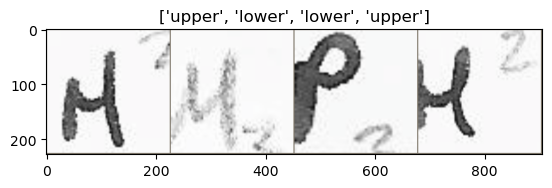

In [109]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

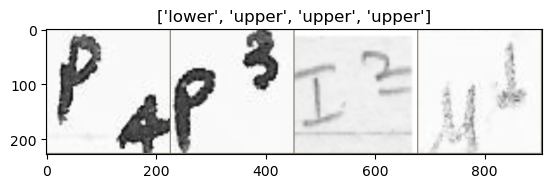

In [110]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [111]:
model_conv = torchvision.models.vit_b_16(weights='DEFAULT')
for param in list(model_conv.parameters())[:-1*LAYERS_TRAINED]:
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.classifier[6].in_features
# model_conv.classifier[6] = nn.Linear(num_ftrs, target_num_of_classes)
num_ftrs = model_conv.heads[0].in_features
model_conv.heads[0] = nn.Linear(num_ftrs, target_num_of_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.heads[0].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

for param in model_conv.parameters():
    print(param.requires_grad)
model_conv

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [112]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_train_acc = 0.0
    best_test_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'test':
                best_test_acc = epoch_acc.item()
            if phase == 'train':
                best_train_acc = epoch_acc.item()

        print()

    print(f'Best val Acc: {best_test_acc:4f}')

    return model, best_train_acc, best_test_acc

In [113]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [114]:
model_conv, train_acc, test_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/24
----------
train Loss: 0.6368 Acc: 0.6423
test Loss: 0.6078 Acc: 0.6750

Epoch 1/24
----------
train Loss: 0.4474 Acc: 0.8000
test Loss: 0.5136 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.3532 Acc: 0.8338
test Loss: 0.4227 Acc: 0.8000

Epoch 3/24
----------
train Loss: 0.2925 Acc: 0.8873
test Loss: 0.4175 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.2791 Acc: 0.8930
test Loss: 0.4243 Acc: 0.8500

Epoch 5/24
----------
train Loss: 0.2762 Acc: 0.8958
test Loss: 0.4254 Acc: 0.8500

Epoch 6/24
----------
train Loss: 0.2418 Acc: 0.9296
test Loss: 0.4386 Acc: 0.8250

Epoch 7/24
----------
train Loss: 0.1951 Acc: 0.9296
test Loss: 0.3734 Acc: 0.8500

Epoch 8/24
----------
train Loss: 0.2013 Acc: 0.9408
test Loss: 0.3955 Acc: 0.8750

Epoch 9/24
----------
train Loss: 0.1893 Acc: 0.9606
test Loss: 0.3704 Acc: 0.8500

Epoch 10/24
----------
train Loss: 0.1970 Acc: 0.9465
test Loss: 0.3778 Acc: 0.8500

Epoch 11/24
----------
train Loss: 0.1846 Acc: 0.9521
test Loss: 0.3715 Acc

KeyboardInterrupt: 

In [ ]:
print(test_acc)

0.825


In [ ]:
print(train_acc)

0.9521


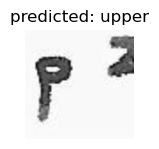

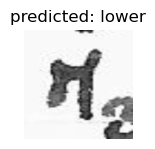

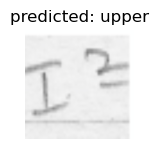

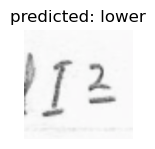

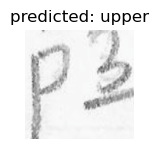

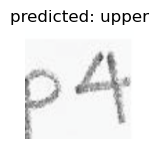

In [ ]:

visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
model_pt_filename = f'{experiment}.pt'
torch.save(model_conv, model_pt_filename)

In [ ]:
# %env MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
# mlflow.set_experiment(experiment)

# params = {
#     'data_v': [3,4,5],
#     'train_size': dataset_sizes['train'],
#     'test_size': dataset_sizes['test'],
#     'batch_size': BATCH_SIZE,
#     'num_epochs': NUM_EPOCHS,
#     'base_model_path': 'torchvision.models.vit_v_16',
#     'preprocessing': 'grayscaling, normalization, random crop',
#     'layers_trained': LAYERS_TRAINED
# }

# # Start an MLflow run
# with mlflow.start_run():
#     # Log the hyperparameters
#     mlflow.log_params(params)

#     # Log the loss metric
#     mlflow.log_metric("most frequent class occurence fraction", fraction)
#     mlflow.log_metric("training accuracy", train_acc)
#     mlflow.log_metric("test accuracy", test_acc)

#     mlflow.log_artifact(model_pt_filename)

#     # Set a tag that we can use to remind ourselves what this run was for
#     mlflow.set_tag("info", "ViT, basic finetuning. Hyperparameters are from a notebook optimized for CNN training, worse result could be because of that. Converged in test accuracy after 8 epochs, did not majorly overfit.")

env: MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
